In [220]:
#!pip install cvxopt

In [338]:
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt

#Seeting the number of stocks
n_pairs = 100 #5 for trying, 30 for pretty graph, 100 for the paper
n_obs_per_sieres = 10000

mu_scale = 0.5
sig_max = 2

#Drawing n_pairs pairs of mean and variance
mu1 = np.random.uniform(low=-mu_scale, high=mu_scale, size=n_pairs)
#mu1 = np.random.uniform(low=0, high=mu_scale, size=n_pairs)
sig1 = np.random.uniform(low=0, high=sig_max, size=n_pairs)

#Drawing random series using mean and variance
group1 = np.random.normal(mu1, sig1, size=(n_obs_per_sieres, n_pairs))
# group1 = np.random.normal(mu1, mu1**2, size=(n_obs_per_sieres, n_pairs))
group1_p = copy.deepcopy(group1)
group1_n = copy.deepcopy(group1)
group1_n[group1_n>0]=0

#Getting the mean
group1_mu = np.mean(group1, axis=0)
group1_std = np.std(group1, axis=0)
group1_lp = -1*np.mean(group1_n, axis=0)


print(group1[:,0])

[ 0.15663096 -0.76736922 -0.34605503 ...  0.31243862  0.02086032
 -0.23849697]


In [327]:
##Pairwise comparsion for the modified MV rule
# nPSD_t = []
# for k in np.arange(0, n_pairs, 1).tolist():
#     for l in np.arange(0, n_pairs, 1).tolist():
#         if (k != l) and (k not in nPSD_t) and (group1_mu[l]>group1_mu[k]) and (group1_lp[l]<=group1_lp[k]) and (group1_std[l]>group1_std[k]):
#             nPSD.append(k)
#             print(k,l)
#             print(group1_mu[k]/group1_std[k], group1_mu[l]/group1_std[l])

# returns_n = copy.deepcopy(returns)
# risks_n = copy.deepcopy(risks)
            
# #Delete dominated porfolios in PSD sense 
# for q in nPSD_t[::-1]: #To keep the order correct, we start from the end towards the first
#     del returns_n[q]
#     del risks_n[q]

#print(nPSD)

In [274]:
from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

n = n_pairs

cov = np.cov(group1.T,ddof=0) #Caculate covariance matrix is different with variance. It works on Transpose.
covm = matrix(cov)

#Return of asset
pbar = matrix(group1_mu)

#G is contraints for inequality
#h is the values of the inequality contraints
#G*x <= h
#Create nxn matrix
G = matrix(0.0, (n,n))
#a[start:stop:step] means start through not past stop, by step
G[::n+1] = -1.0 #The terms in the diagonal is -1
h = matrix(0.0, (n,1))
#  A*x = b. We have one equality contraint
A = matrix(1.0, (1,n))
b = matrix(1.0)

In [275]:
#Modifed from https://cvxopt.org/userguide/coneprog.html#quadratic-programming
import math
import time
import numpy as np

start_time = time.time()

#Example from cvxopt
# N = 100
# mus = [ 10**(5.0*t/N-1.0) for t in range(N) ]
# xs = [ qp(mu*covm, -pbar, G, h, A, b)['x'] for mu in mus ]


#Weight to objective
n_part = 100 # means n_part objectives
gamma_min = 0.0001
gamma_max = 0.9999
gamma1 = np.arange(gamma_min, gamma_max, (1-gamma_min)/n_part).tolist()


def solve_por():
    xs = []
    for c1 in gamma1:
            c3 = 1 - c1 
            xs.append(qp(c3*covm, -c1*pbar, G, h, A, b)['x']) 
            print(c1,c3)
    return xs
xs = solve_por()



#Weighted series
ws = [ group1*list(x) for x in xs ]
#Weighted returns
wr = [np.sum(s, axis=1) for s in ws]
wr_l = copy.deepcopy(wr)


# Make all positive value become zero
for k in np.arange(0, n_part, 1).tolist():
    wr_l[k][wr_l[k]>0]=0


# The expected return of the profolios
returns = [ dot(pbar,x) for x in xs ]
# The variance of the profolio
risks = [ sqrt(dot(x, covm*x)) for x in xs ]

# The lower partial moment of portofolios
low_p = [ -1*np.mean(wl, axis=0) for wl in wr_l ]


# print("--- %s seconds ---" % (time.time() - start_time))

     pcost       dcost       gap    pres   dres
 0:  2.9828e-03 -1.0030e+00  1e+00  0e+00  1e+01
 1:  2.9437e-03 -1.2925e-02  2e-02  3e-17  2e-01
 2:  1.9433e-03 -2.0188e-03  4e-03  3e-16  3e-02
 3:  1.1484e-03 -2.1934e-03  3e-03  1e-15  2e-02
 4:  4.4622e-04 -4.5284e-04  9e-04  2e-16  3e-03
 5:  6.4780e-04 -7.9037e-04  1e-03  2e-16  8e-18
 6:  2.4094e-04 -3.2515e-04  6e-04  2e-16  8e-18
 7:  1.5026e-04  8.2273e-05  7e-05  1e-16  7e-18
 8:  1.3387e-04  1.2598e-04  8e-06  1e-16  3e-18
 9:  1.3258e-04  1.3201e-04  6e-07  2e-17  1e-18
10:  1.3251e-04  1.3248e-04  3e-08  1e-16  7e-19
Optimal solution found.
0.0001 0.9999
     pcost       dcost       gap    pres   dres
 0:  3.2325e-03 -1.0049e+00  1e+00  3e-16  1e+01
 1:  3.1860e-03 -1.4812e-02  2e-02  1e-16  2e-01
 2:  1.9481e-03 -3.0444e-03  5e-03  2e-17  4e-02
 3:  4.6347e-04 -2.9878e-03  3e-03  2e-16  2e-04
 4: -3.6369e-05 -8.9932e-04  9e-04  1e-16  3e-05
 5: -2.4072e-04 -3.5446e-04  1e-04  4e-17  1e-17
 6: -2.8421e-04 -2.9554e-04  1e-0

 2: -1.5541e-03 -4.0540e-01  4e-01  4e-16  3e-15
 3: -1.2701e-02 -9.4716e-02  8e-02  3e-16  1e-15
 4: -5.0276e-02 -1.2363e-01  7e-02  2e-16  4e-16
 5: -5.8775e-02 -7.9895e-02  2e-02  2e-16  4e-16
 6: -6.0485e-02 -7.0429e-02  1e-02  3e-16  2e-16
 7: -6.5724e-02 -6.6387e-02  7e-04  7e-17  4e-16
 8: -6.6184e-02 -6.6197e-02  1e-05  2e-16  3e-16
 9: -6.6195e-02 -6.6195e-02  2e-07  2e-16  3e-16
10: -6.6195e-02 -6.6195e-02  2e-09  2e-16  3e-16
Optimal solution found.
0.21007900000000002 0.789921
     pcost       dcost       gap    pres   dres
 0: -1.6836e-01 -1.1098e+00  1e+02  1e+01  1e+01
 1: -1.9478e-02 -1.0607e+00  3e+00  2e-01  2e-01
 2: -2.4089e-03 -4.1952e-01  4e-01  6e-16  3e-15
 3: -1.4248e-02 -9.9141e-02  8e-02  2e-16  1e-15
 4: -5.3758e-02 -1.3053e-01  8e-02  2e-16  3e-16
 5: -6.2735e-02 -8.4155e-02  2e-02  7e-17  4e-16
 6: -6.3927e-02 -7.5032e-02  1e-02  3e-16  2e-16
 7: -6.9553e-02 -7.0540e-02  1e-03  1e-16  3e-16
 8: -7.0206e-02 -7.0223e-02  2e-05  2e-16  3e-16
 9: -7.0219e-02 -

 8: -1.5743e-01 -1.5743e-01  2e-06  4e-17  7e-16
 9: -1.5743e-01 -1.5743e-01  1e-07  1e-16  7e-16
Optimal solution found.
0.42005800000000004 0.579942
     pcost       dcost       gap    pres   dres
 0: -7.6128e-01 -1.2836e+00  1e+02  1e+01  1e+01
 1: -1.0867e-01 -1.1528e+00  4e+00  3e-01  2e-01
 2: -2.6443e-02 -6.4200e-01  6e-01  7e-16  2e-15
 3: -5.6358e-02 -1.9192e-01  1e-01  2e-16  1e-15
 4: -1.3140e-01 -2.5002e-01  1e-01  3e-16  6e-16
 5: -1.5079e-01 -1.7934e-01  3e-02  2e-16  6e-16
 6: -1.5922e-01 -1.6384e-01  5e-03  2e-16  5e-16
 7: -1.6202e-01 -1.6209e-01  7e-05  9e-17  5e-16
 8: -1.6206e-01 -1.6207e-01  1e-06  1e-16  6e-16
 9: -1.6207e-01 -1.6207e-01  4e-08  2e-16  6e-16
Optimal solution found.
0.430057 0.569943
     pcost       dcost       gap    pres   dres
 0: -8.0290e-01 -1.2933e+00  1e+02  1e+01  1e+01
 1: -1.1421e-01 -1.1574e+00  4e+00  3e-01  2e-01
 2: -2.7841e-02 -6.4970e-01  6e-01  9e-16  2e-15
 3: -5.8792e-02 -1.9631e-01  1e-01  4e-16  1e-15
 4: -1.3499e-01 -2.5470e-

 8: -2.6659e-01 -2.6659e-01  7e-07  1e-16  7e-16
 9: -2.6659e-01 -2.6659e-01  3e-08  2e-16  8e-16
Optimal solution found.
0.650035 0.34996499999999997
     pcost       dcost       gap    pres   dres
 0: -2.1448e+00 -1.5218e+00  2e+02  1e+01  7e+00
 1: -2.4145e-01 -1.2588e+00  5e+00  3e-01  2e-01
 2: -6.1716e-02 -7.7655e-01  7e-01  2e-16  1e-15
 3: -1.2012e-01 -2.9520e-01  2e-01  2e-17  1e-15
 4: -2.2543e-01 -3.4183e-01  1e-01  1e-16  5e-16
 5: -2.5832e-01 -2.8083e-01  2e-02  8e-17  7e-16
 6: -2.7031e-01 -2.7179e-01  1e-03  2e-16  7e-16
 7: -2.7141e-01 -2.7143e-01  2e-05  3e-16  7e-16
 8: -2.7142e-01 -2.7142e-01  6e-07  2e-16  7e-16
 9: -2.7142e-01 -2.7142e-01  7e-08  1e-16  7e-16
Optimal solution found.
0.660034 0.339966
     pcost       dcost       gap    pres   dres
 0: -2.2298e+00 -1.5319e+00  2e+02  1e+01  7e+00
 1: -2.4613e-01 -1.2634e+00  5e+00  3e-01  2e-01
 2: -6.3411e-02 -7.7939e-01  7e-01  1e-15  2e-15
 3: -1.2329e-01 -3.0054e-01  2e-01  7e-16  1e-15
 4: -2.3295e-01 -3.4431e-

 2: -1.1214e-01 -5.7942e-01  5e-01  4e-16  1e-15
 3: -3.1046e-01 -4.1711e-01  1e-01  4e-16  9e-16
 4: -3.7808e-01 -4.0123e-01  2e-02  4e-17  5e-16
 5: -3.9554e-01 -3.9872e-01  3e-03  2e-16  6e-16
 6: -3.9829e-01 -3.9836e-01  7e-05  2e-16  6e-16
 7: -3.9835e-01 -3.9835e-01  7e-07  3e-16  6e-16
 8: -3.9835e-01 -3.9835e-01  7e-09  2e-16  7e-16
Optimal solution found.
0.9100090000000001 0.08999099999999993
     pcost       dcost       gap    pres   dres
 0: -5.5631e+00 -1.6259e+00  2e+02  1e+01  6e+00
 1: -1.7604e-01 -1.3765e+00  3e+00  1e-01  6e-02
 2: -1.1389e-01 -5.5182e-01  4e-01  6e-16  1e-15
 3: -3.3363e-01 -4.5617e-01  1e-01  1e-16  7e-16
 4: -3.8953e-01 -4.0971e-01  2e-02  4e-16  7e-16
 5: -4.0209e-01 -4.0507e-01  3e-03  3e-16  7e-16
 6: -4.0438e-01 -4.0445e-01  7e-05  7e-17  8e-16
 7: -4.0444e-01 -4.0444e-01  1e-06  9e-17  8e-16
 8: -4.0444e-01 -4.0444e-01  1e-08  6e-17  6e-16
Optimal solution found.
0.920008 0.07999199999999995
     pcost       dcost       gap    pres   dres
 0: 

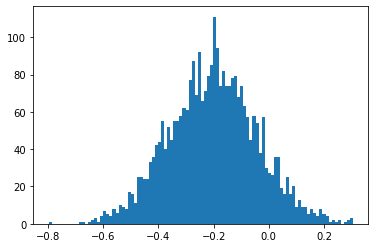

In [328]:
# #Histogram
# plt.hist(wr[0], bins = 100)
# plt.show()

In [276]:
nPSD = []
for k in np.arange(0, n_part, 1).tolist():
    for l in np.arange(0, n_part, 1).tolist():
        if (k != l) and (k not in nPSD) and (returns[l]>returns[k]) and (low_p[l]<=low_p[k]) and (risks[l]>risks[k]):
            nPSD.append(k)
            print(k,l)
            print(returns[k]/risks[k], returns[l]/risks[l])

returns_n = copy.deepcopy(returns)
risks_n = copy.deepcopy(risks)
            
#Delete dominated porfolios in PSD sense 
for q in nPSD[::-1]: #To keep the order correct, we start from the end towards the first
    del returns_n[q]
    del risks_n[q]

print(nPSD)

0 1
-11.119050586671113 2.9410292426954654
1 2
2.9410292426954654 3.0916346056621453
[0, 1]


(0.0, 0.5430812499840337)

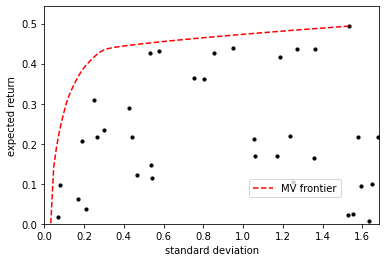

In [277]:
import pylab

# Plot trade-off curve and optimal allocations.
pylab.figure(1, facecolor='w')
pylab.plot(risks, returns, 'r--',label='MV frontier') 
plt.scatter(group1_std, group1_mu, c ="black",s=10)
#plt.scatter(risks, returns, c ="red")
pylab.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
pylab.xlim(0, max(risks)*1.1)
pylab.ylim(0, max(returns)*1.1)
#pylab.title('Risk-return trade-off curve')

Text(0, 0.5, 'expected return')

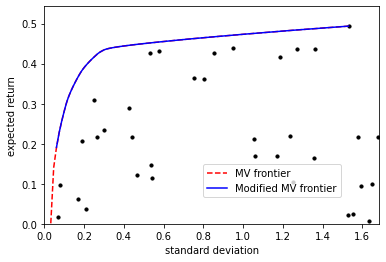

In [278]:
import pylab

# Plot trade-off curve and optimal allocations.
pylab.figure(1, facecolor='w')
pylab.plot(risks, returns, 'r--',label='MV frontier') 
pylab.plot(risks_n, returns_n, 'b-',label='Modified MV frontier')
#Scatter to shows portofolios
#plt.scatter(risks, returns, c ="red")
#plt.scatter(risks_n, returns_n, c ="blue")


plt.scatter(group1_std, group1_mu, c ="black",s=10)
pylab.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
pylab.xlim(0, max(risks)*1.1)
pylab.ylim(0, max(returns)*1.1)
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
#pylab.title('Risk-return trade-off curve')

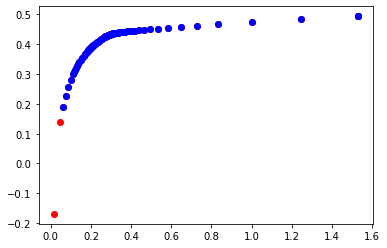

In [279]:
import matplotlib.pyplot as plt


plt.scatter(risks, returns, c ="red")
plt.scatter(risks_n, returns_n, c ="blue")
# To show the plot
plt.show()